# <center><font color='red'>CLASSIFIERS</font></center>

### <center><font color='orange'>AUTHOR: Diogo Vieira</font></center>

-------------------------------------------

### <center><font color='grey'>Imports</font></center>

#### <center><font color='grey'>Libraries</font></center>

In [1]:
# Math, image processing and other useful libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os

import pandas as pd
import numpy as np
import cv2
from collections import OrderedDict
import copy
import math
import pickle
from matplotlib.ticker import MaxNLocator
from itertools import combinations

# Image processing
from skimage.measure import regionprops
from skimage.filters import meijering, sato, frangi, hessian, threshold_otsu
from skimage.morphology import extrema, skeletonize
from skimage.transform import probabilistic_hough_line
from skimage.draw import disk, circle_perimeter
from scipy.ndimage import gaussian_filter, grey_closing
from scipy.spatial import distance_matrix
from skimage import data, restoration, util
from roipoly import RoiPoly
from matplotlib_scalebar.scalebar import ScaleBar
from biosppy.signals import tools
from biosppy.stats import pearson_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import matplotlib.colors as colors
import seaborn as sns

# Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

# Feature Extraction (.py files by Teresa Parreira)
# from CytoSkeletonPropsMorph import CytoSkeletonPropsMorph
# from CytoSkeletonRegionPropsInt import RegionPropsInt
# from FreqAnalysis import FreqAnalysis
# from GLCM import GLCM

# Graph
import sknw
import networkx as nx
from scipy.signal import argrelextrema

# 
from skan import Skeleton, summarize,draw
from skan.csr import skeleton_to_csgraph, sholl_analysis,make_degree_image
import scipy as sp
import scipy.sparse
from matplotlib.patches import Circle
from framework.ImageFeatures import ImageFeatures,getvoxelsize
from framework.Functions import cv2toski,pylsdtoski,polar_to_cartesian, remove_not1D, quantitative_analysis,hist_bin,hist_lim,branch,graphAnalysis
from framework.Importing import *
from framework.PreProcessingCYTO import *
#from framework.PreProcessingNUCL import excludeborder, nuclei_preprocessing, df_nuclei_preprocessing, nuclei_segmentation
from framework.Processing import process3Dnuclei,analyze_cell,statistics_from_2D_features,create_separate_DFs
from framework.visualization import *
from framework.analysis import plot_barplot
#from fractal_dimension import fractal_dimension
#from fractal_analysis_fxns import boxcount,boxcount_grayscale,fractal_dimension,fractal_dimension_grayscale,fractal_dimension_grayscale_DBC
from framework.PCAFunctions import *

print('ðŸ“š All libraries successfully imported ðŸ“š')

ðŸ“š All libraries successfully imported ðŸ“š


---

#### <center><font color='grey'>Directories</font></center>

In [2]:
### DATASET #1 (2D)
folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 1-a-tubulin_Sofia"
options   = ["CYTO","NUCL"]
denominator = label_tubulin

### DATASET #2 (3D)
# folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 3D"
# options     = ["CYTO3D","NUCL3D"]
# denominator = label_tubulin3D

### DATASET #3 (Soraia)
# folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Soraia"
# options     = ["CYTO","NUCL"]
# denominator = label_soraia

### DATASET #4 (InÃªs)
# folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Ines"
#options     = []
# denominator  =

### DATASET #4 (SPOCC)
# folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\SPOCC2022"
# options     = ["CYTO"]
# denominator = label_SPOCC

data = init_import(folder,options,denominator)
data['NUCL_PRE'] = pd.read_pickle(folder + "\\NUCL_PRE\\NUCL_PRE.pkl") # pd.read_pickle(os.getcwd() + "\\NUCL_PRE_2D_StarDist.pkl") #
data['CYTO_PRE'] = pd.read_pickle(folder + "\\CYTO_PRE\\CYTO_PRE.pkl") 

ResultsDF = pd.read_pickle(folder + "\\ResultsDF_5_nov_23.pkl")
#TextureDF = pd.read_pickle("TextureDF_paper.pkl")
CentroidsDF = pickle.load(open(folder + '\\Centroids.p', 'rb'))  
#ResultsDF = pd.read_pickle(folder + "\\ResultsDF_try.pkl")
#ResultsDF = pd.read_pickle(folder + "\\ResultsDF.pkl")

>>> [CYTO] added.
>>> [NUCL] added.


In [3]:
ResultsDF

Name Img Index            Label  \
0     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
1     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
2     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
3     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
4     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
...                                       ...       ...              ...   
1041  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1042  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1043  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1044  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1045  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   

                                                   Mask  \
0     [[False, False, False, False, False, False, Fa...   
1     [[False, False, False, False, False, False, Fa...   
2     [[False, False, False, False, False, False, Fa...   
3     [[False, False, False, False, False, False, Fa...   
4     [[False, False, False, False, False, False, Fa...   
...                                                 ...   
1041  [[False, False, False, False, False, False, Fa...   
1042  [[False, False, False, False, False, False, Fa...   
1043  [[False, False, False, False, False, False, Fa...   
1044  [[False, False, False, False, False, False, Fa...   
1045  [[False, False, False, False, False, False, Fa...   

                                                Patches  \
0     [[[False, False, False, False, False, False, F...   
1     [[[False, False, False, False, False, False, F...   
2     [[[False, False, False, False, False, False, F...   
3     [[[False, True, False, False, False, False, Fa...   
4     [[[False, True, True, False, False, False, Fal...   
...                                                 ...   
1041  [[[True, False, False, False, False, False, Fa...   
1042  [[[False, False, False, False, False, False, F...   
1043  [[[False, False, False, False, False, False, F...   
1044  [[[False, True, False, False, False, False, Fa...   
1045  [[[False, False, False, False, False, False, F...   

                                                  Lines  \
0     [((846.96, 125.385), (843.154, 135.458)), ((90...   
1     [((1226.05, 591.863), (1229.906, 588.782)), ((...   
2     [((826.21, 118.655), (825.066, 124.886)), ((82...   
3     [((881.97, 87.737), (872.975, 72.653)), ((879....   
4     [((919.221, 167.758), (920.078, 160.075)), ((9...   
...                                                 ...   
1041  [((1302.876, 636.71), (1315.898, 650.104)), ((...   
1042  [((1219.212, 675.053), (1225.331, 671.735)), (...   
1043  [((1159.001, 629.746), (1157.546, 625.154)), (...   
1044  [((1066.295, 639.445), (1070.276, 642.75)), ((...   
1045  [((666.684, 959.794), (674.218, 953.386)), ((6...   

                                                  Graph  \
0     [  (1, 2)\t1.0\n  (2, 1)\t1.0\n  (2, 4)\t1.0\n...   
1     [  (1, 2)\t1.0\n  (2, 1)\t1.0\n  (2, 4)\t1.414...   
2     [  (1, 2)\t1.0\n  (2, 1)\t1.0\n  (2, 3)\t1.414...   
3     [  (1, 2)\t1.0\n  (2, 1)\t1.0\n  (2, 3)\t1.414...   
4     [  (1, 2)\t1.0\n  (1, 3)\t1.4142135623730951\n...   
...                                                 ...   
1041  [  (1, 2)\t1.0\n  (2, 1)\t1.0\n  (2, 3)\t1.414...   
1042  [  (1, 3)\t1.4142135623730951\n  (2, 4)\t1.0\n...   
1043  [  (1, 2)\t1.0\n  (1, 7)\t1.4142135623730951\n...   
1044  [  (2, 3)\t1.0\n  (3, 2)\t1.0\n  (3, 4)\t1.414...   
1045  [  (2, 3)\t1.0\n  (3, 2)\t1.0\n  (3, 4)\t1.0\n...   

                                           LSF2D:Angles  \
0     [24.256, 56.447, 77.093, 39.697, 65.666, 64.38...   
1     [11.074, 26.265, 40.852, 6.218, 77.168, 26.269...   
2     [28.672, 55.951, 31.395, 27.53, 25.057, 22.241...   
3     [20.094, 57.405, 61.997, 11.955, 15.799, 30.33... 

# PCA

In [3]:
sep = create_separate_DFs(ResultsDF,options=["FULL"])
FULL = sep["FULL"]

In [23]:
def remove_redundant(DF, corr_thr):
    redExtractedFeat     = [x for x in DF.columns if x.startswith("LSF1D") or x.startswith("DCF") or x.startswith("DNF") or x.startswith("SKNW") or x.startswith("OTHERS")]
    #redExtractedFeat = DF.columns
    trmv = []
    red_feature_vector = copy.deepcopy(DF).to_numpy()
    #red_feature_vector = red_feature_vector.iloc[: , 8:].to_numpy()
    
    while 1:
        oldF = redExtractedFeat
        
        # combine current set of features, two at a time
        comb = combinations(range(len(oldF)), 2) 
        
        for f in list(comb):
            # find correlation between the two features in analysis
            corr = pearson_correlation(red_feature_vector[:, f[0]], red_feature_vector[:, f[1]])[0]
            
            if corr > corr_thr:
                #print("Highly Corr: ", oldF[f[0]], oldF[f[1]], corr)
                trmv += [redExtractedFeat[f[0]]]
                redExtractedFeat = np.delete(oldF, f[0])
                red_feature_vector = np.delete(red_feature_vector, f[0], axis=1)
                break
                
        if len(redExtractedFeat) == len(oldF):
            break
    
    return red_feature_vector,redExtractedFeat 

In [24]:
# PCA
# ESCOLHER: LSF,DCF,DNF or FULL
DF = FULL

print('Initial Number of Features: ' + str(len(DF.columns)))

# Removal of redundant features - one of the features of pairs with Pearson correlation >thr
global redFeatLabels
redFeatMatrix,redFeatLabels = remove_redundant(DF,0.99) 

Initial Number of Features: 315
[]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Perform redudant feature analysis
thr_redundant_analysis((0.5,1,0.05),DF)
#plt.savefig(".//ResultsGenAnalysis//Hough26Mar//PCA - DNF//thr_analysis.png",format='png',transparent=True,bbox_inches='tight')

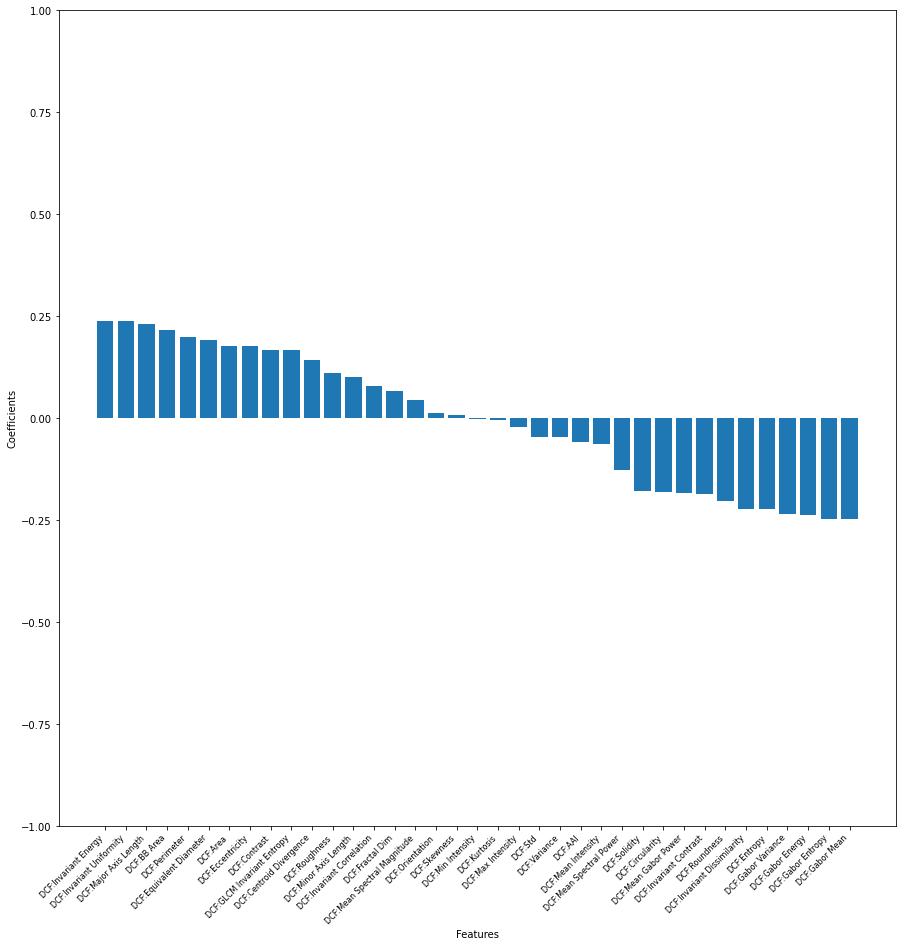

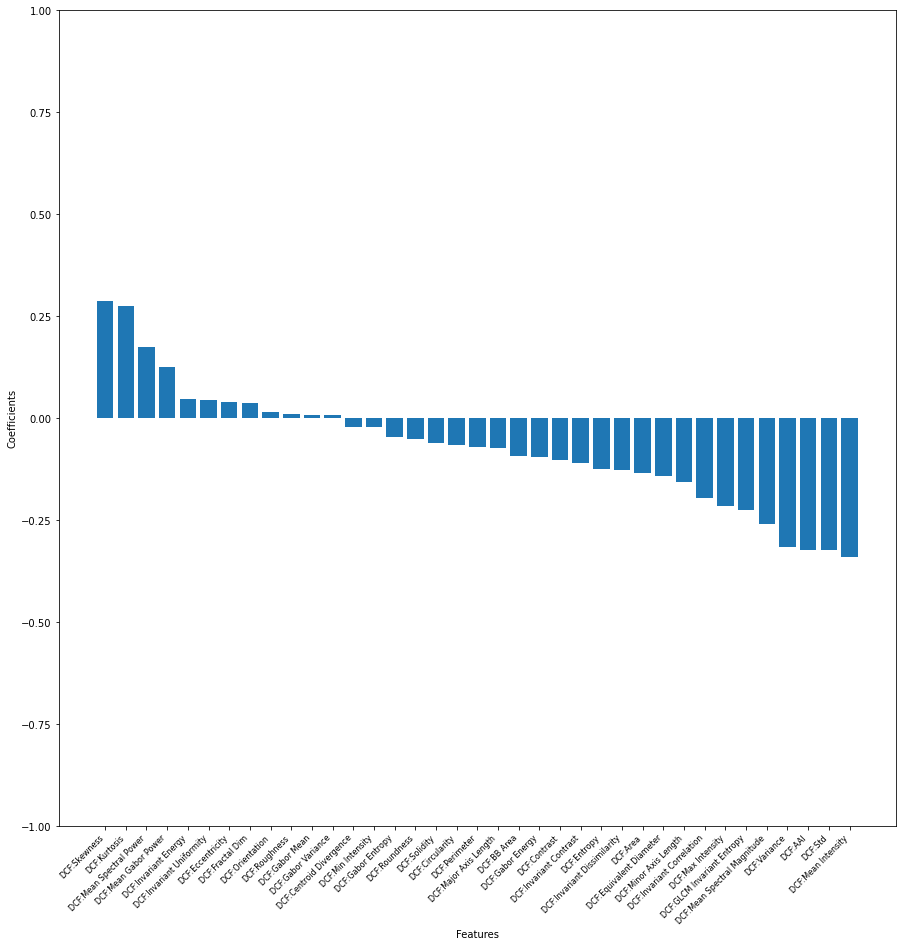

In [10]:
# Plot PC0 and PC1 coefficients
plot_pca_coefficients(redFeatLabels,redFeatMatrix)

working...


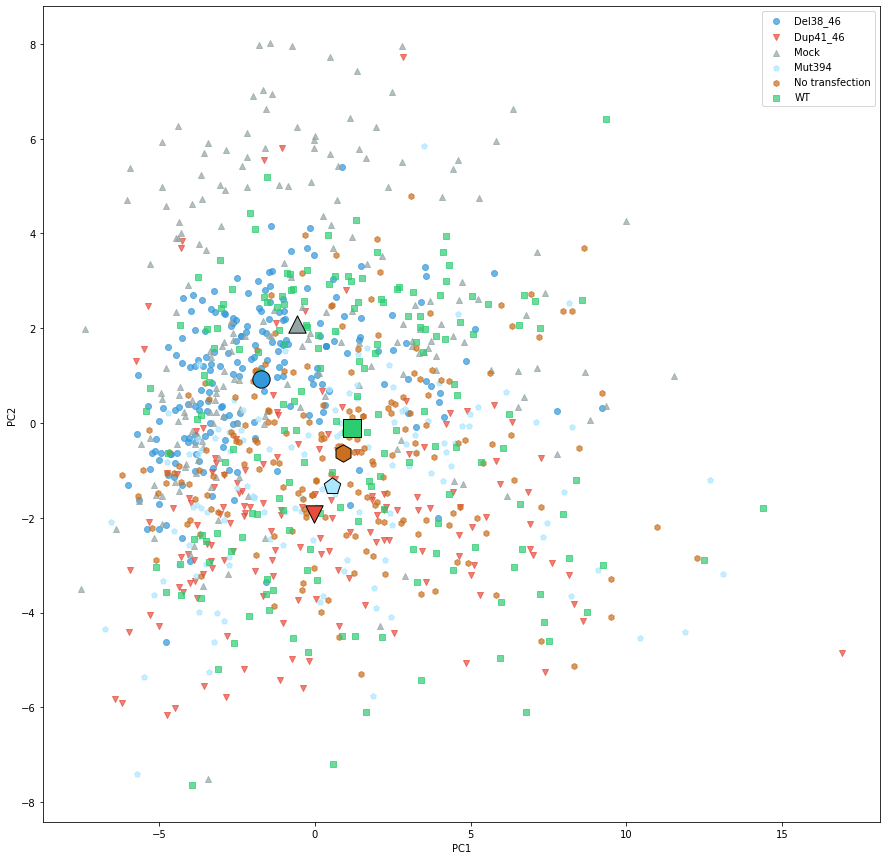

Final Number of Features: 37
Variances from PC0, PC1 and PC2: [0.3882832  0.18723321 0.098753  ]
Total Variance Explained (2D) = 0.5755164090046454
Total Variance Explained (3D) = 0.6742694100321087


In [11]:
plot_PCA(redFeatMatrix,redFeatLabels,ResultsDF)

In [66]:
for i in range(len(FULL.columns)):
    print(str(FULL.columns[i]) + str(" = ") + str(len(np.unique(FULL[FULL.columns[i]].isnull()))))

Angles mean = 1
Angles median = 1
Angles min = 1
Angles max = 1
Angles max_amp = 1
Angles var = 1
Angles std_dev = 1
Angles abs_dev = 1
Angles kurtosis = 1
Angles skewness = 1
Distances to Centroid mean = 1
Distances to Centroid median = 1
Distances to Centroid min = 1
Distances to Centroid max = 1
Distances to Centroid max_amp = 1
Distances to Centroid var = 1
Distances to Centroid std_dev = 1
Distances to Centroid abs_dev = 1
Distances to Centroid kurtosis = 1
Distances to Centroid skewness = 1
Triangle Areas mean = 1
Triangle Areas median = 1
Triangle Areas min = 1
Triangle Areas max = 1
Triangle Areas max_amp = 1
Triangle Areas var = 1
Triangle Areas std_dev = 1
Triangle Areas abs_dev = 1
Triangle Areas kurtosis = 1
Triangle Areas skewness = 1
Line Lengths mean = 1
Line Lengths median = 1
Line Lengths min = 1
Line Lengths max = 1
Line Lengths max_amp = 1
Line Lengths var = 1
Line Lengths std_dev = 1
Line Lengths abs_dev = 1
Line Lengths kurtosis = 1
Line Lengths skewness = 1
Theta 

In [ ]:
kmeans = KMeans(n_clusters=3, random_state = 42).fit(DCF)
result = kmeans.predict(df_img)

plt.imshow(result, cmap='twilight');

## Separate Analysis

In [21]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)
# Perform interactive PCA visualization
def plot_PCA_1(array,labels,ResultsDF,wid_list,data_type):
    # Get hover data type
    if data_type == 'LSF':
        type_ind = 0
    if data_type == 'DCF':
        type_ind = 1
    if data_type == 'DNF':
        type_ind = 2
    
    # Colors and Markers
    colors  = ["#3498DB","#E74C3C","#95A5A6","#ABE6FF","#CA6F1E","#2ECC71"]
    markers = ["o","v","^","p","h","s"]
    
    # STD normalization, PCA
    global feats_PCA
    redFeatMatrix               = StandardScaler().fit_transform(array)
    pca                         = PCA(n_components='mle', random_state=0, svd_solver = 'full')
    feats_PCA                   = pca.fit_transform(redFeatMatrix)

    # Labels
    global ls
    ls = np.unique(ResultsDF['Label'])
    print(ls)
    c = [colors[list(ls).index(x)] for x in ResultsDF['Label']]
    m = [markers[list(ls).index(y)] for y in ResultsDF['Label']]

    # Plot 2D
    fig, ax = plt.subplots(figsize=(15,15))
    #plt.figure(figsize=(15,15))
    clusterpoints = feats_PCA[:,0:2]

    for p in range(len(ls)):
        #global d,unique,u,points
        d = ResultsDF[ResultsDF['Label'] == ls[p]]
        points = clusterpoints[ResultsDF['Label'] == ls[p]]
        
        if wid_list[p] == True:
            # print(wid_list[p])
            sc = ax.scatter(points[:,0],points[:,1],c=colors[p],marker=markers[p],label=ls[p],zorder=4,alpha=0.7)
            
            unique = d.index
            
            #for poi in range(len(points[:,0])):
                
            #fig1, ax1 = plt.subplots(figsize=(5,5))
            #arr = np.arange(100).reshape((10, 10))

            global annot
            annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points", arrowprops=dict(arrowstyle="->"))
            #ax.add_artist(ab)
            annot.set_visible(False)

            def update_annot(ind):
                global pos
                pos = sc.get_offsets()[ind["ind"][0]]
                #pos = sc.get_offsets()[ind["ind"]]
                   
                im = OffsetImage(d.loc[[unique[n] for n in ind["ind"]][0]]['Patches'][type_ind], zoom=1,cmap='gray')
                #im = OffsetImage(d.loc[unique[ind["ind"]]]['Patches'][1], zoom=0.2)
                im.image.axes = ax
                #annot = AnnotationBbox(im, (points[:,0][ind["ind"][0]],points[:,1][ind["ind"][0]]), xybox=(-50., 50.), xycoords='data', boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->"))
                
                annot = AnnotationBbox(im, (pos[0],pos[1]), xybox=(-50., 50.), xycoords='data', boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->"))
                
                annot.xy = pos
                #annot1 = AnnotationBbox(im, (pos[0][1],pos[0][0]), xybox=(-50., 50.), xycoords='data', boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->"))

                ax.add_artist(annot)

            def hover(event):
                vis = annot.get_visible()
                if event.inaxes == ax:
                    global ind
                    cont, ind = sc.contains(event)
                    if cont:
                        update_annot(ind)
                        annot.set_visible(True)
                        fig.canvas.draw_idle()
                    else:
                        if vis:
                            annot.set_visible(False)
                            fig.canvas.draw_idle()

            fig.canvas.mpl_connect("motion_notify_event", hover)

        else:
            ax.scatter(points[:,0],points[:,1],c='w',marker=markers[p],label=ls[p],zorder=1,alpha=0.7)
            #print(wid_list[p])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()

    # mid point
    for p in range(len(ls)):
        points = clusterpoints[ResultsDF['Label'] == ls[p]]
        if wid_list[p] == True:
            ax.scatter(np.mean(points,axis=0)[0],np.mean(points,axis=0)[1],c=colors[p],marker=markers[p],label=ls[p],s=300,edgecolors='k',zorder=5,alpha=0.5)
        else:
            ax.scatter(points[:,0],points[:,1],c='w',marker=markers[p],label=ls[p],zorder=1,alpha=0.5)

    plt.show()

---

In [24]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)
# Perform interactive PCA visualization
def plot_PCA_1(array,labels,ResultsDF,wid_list,data_type):
    # Get hover data type
    if data_type == 'LSF':
        type_ind = 0
    if data_type == 'DCF':
        type_ind = 1
    if data_type == 'DNF':
        type_ind = 2
    
    # Colors and Markers
    colors  = ["#3498DB","#E74C3C","#95A5A6","#ABE6FF","#CA6F1E","#2ECC71"]
    markers = ["o","v","^","p","h","s"]
    
    # STD normalization, PCA
    global feats_PCA
    redFeatMatrix               = StandardScaler().fit_transform(array)
    pca                         = PCA(n_components='mle', random_state=0, svd_solver = 'full')
    feats_PCA                   = pca.fit_transform(redFeatMatrix)

    # Labels
    global ls,c,m
    ls = np.unique(ResultsDF['Label'])
    print(ls)
    c = [colors[list(ls).index(x)] for x in ResultsDF['Label']]
    m = [markers[list(ls).index(y)] for y in ResultsDF['Label']]

    # Plot 2D
    fig, ax = plt.subplots(figsize=(15,15))
    clusterpoints = feats_PCA[:,0:2]

    for p in range(len(ls)):
        #global d,unique,u,points
        d = ResultsDF[ResultsDF['Label'] == ls[p]]
        points = clusterpoints[ResultsDF['Label'] == ls[p]]
        
        if wid_list[p] == True:
            # print(wid_list[p])
            ax.scatter(points[:,0],points[:,1],c=colors[p],marker=markers[p],label=ls[p],zorder=4,alpha=0.7,picker = True)
        else:
            ax.scatter(points[:,0],points[:,1],c='w',marker=markers[p],label=ls[p],zorder=1,alpha=0.7,picker = True)
            #print(wid_list[p])
    
    global sc, unique
    sc = plt.gca().collections[0]
    unique = ResultsDF.index
            
    #for poi in range(len(points[:,0])):

    #fig1, ax1 = plt.subplots(figsize=(5,5))
    #arr = np.arange(100).reshape((10, 10))

    global annot
    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points", arrowprops=dict(arrowstyle="->"))
    #ax.add_artist(ab)
    annot.set_visible(False)

    def update_annot(ind):
        global pos
        pos = sc.get_offsets()[ind["ind"][0]]
        #pos = sc.get_offsets()[ind["ind"]]

        im = OffsetImage(ResultsDF.loc[[unique[n] for n in ind["ind"]][0]]['Patches'][type_ind], zoom=1,cmap='gray')
        #im = OffsetImage(d.loc[unique[ind["ind"]]]['Patches'][1], zoom=0.2)
        im.image.axes = ax
        #annot = AnnotationBbox(im, (points[:,0][ind["ind"][0]],points[:,1][ind["ind"][0]]), xybox=(-50., 50.), xycoords='data', boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->"))

        annot = AnnotationBbox(im, (pos[0],pos[1]), xybox=(-50., 50.), xycoords='data', boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->"))

        annot.xy = pos
        #annot1 = AnnotationBbox(im, (pos[0][1],pos[0][0]), xybox=(-50., 50.), xycoords='data', boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->"))

        ax.add_artist(annot)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            global ind
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()

    # mid point
    for p in range(len(ls)):
        points = clusterpoints[ResultsDF['Label'] == ls[p]]
        if wid_list[p] == True:
            ax.scatter(np.mean(points,axis=0)[0],np.mean(points,axis=0)[1],c=colors[p],marker=markers[p],label=ls[p],s=300,edgecolors='k',zorder=5,alpha=0.5)
        else:
            ax.scatter(points[:,0],points[:,1],c='w',marker=markers[p],label=ls[p],zorder=1,alpha=0.5)

    on_move_id = fig.canvas.mpl_connect("motion_notify_event", hover)
    plt.show()

---

In [20]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)
# Perform interactive PCA visualization
def plot_PCA_1(array,labels,ResultsDF,wid_list,data_type):
    # Get hover data type
    if data_type == 'LSF':
        type_ind = 0
    if data_type == 'DCF':
        type_ind = 1
    if data_type == 'DNF':
        type_ind = 2
    
    # Colors and Markers
    colors  = ["#3498DB","#E74C3C","#95A5A6","#ABE6FF","#CA6F1E","#2ECC71"]
    markers = ["o","v","^","p","h","s"]
    
    # STD normalization, PCA
    global feats_PCA
    redFeatMatrix               = StandardScaler().fit_transform(array)
    pca                         = PCA(n_components='mle', random_state=0, svd_solver = 'full')
    feats_PCA                   = pca.fit_transform(redFeatMatrix)

    # Labels
    global ls,c,m
    ls = np.unique(ResultsDF['Label'])
    print(ls)
    c = [colors[list(ls).index(x)] for x in ResultsDF['Label']]
    m = [markers[list(ls).index(y)] for y in ResultsDF['Label']]

    # Plot 2D
    fig, ax = plt.subplots(figsize=(15,15))
    clusterpoints = feats_PCA[:,0:2]

    for p in range(len(ls)):
        #global d,unique,u,points
        d = ResultsDF[ResultsDF['Label'] == ls[p]]
        points = clusterpoints[ResultsDF['Label'] == ls[p]]
        
        if wid_list[p] == True:
            # print(wid_list[p])
            ax.scatter(points[:,0],points[:,1],c=colors[p],marker=markers[p],label=ls[p],zorder=4,alpha=0.7,picker = True)
        else:
            ax.scatter(points[:,0],points[:,1],c='w',marker=markers[p],label=ls[p],zorder=1,alpha=0.7,picker = True)
            #print(wid_list[p])
    
    
    im = OffsetImage(np.zeros((20,20)), zoom=1,cmap='gray')
    xybox=(50., 50.)
    annot = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data', boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->"))

    
    ax.add_artist(annot)
    annot.set_visible(False)
    
    global sc, unique
    sc = plt.gca().collections[0]
    unique = ResultsDF.index
            
    #for poi in range(len(points[:,0])):

    #fig1, ax1 = plt.subplots(figsize=(5,5))
    #arr = np.arange(100).reshape((10, 10))

    #global annot
    #annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points", arrowprops=dict(arrowstyle="->"))
    #ax.add_artist(ab)
    #annot.set_visible(False)



    
    def hover(event):
        if sc.contains(event)[0]:
            # find out the index within the array from the event
            ind, = sc.contains(event)[1]["ind"]
            w,h = fig.get_size_inches()*fig.dpi
            ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
            hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
            # if event occurs in the top or right quadrant of the figure,
            # change the annotation box position relative to mouse.
            annot.xybox = (xybox[0]*ws, xybox[1]*hs)
            # make annotation box visible
            annot.set_visible(True)
            # place it at the position of the hovered scatter point
            pos = sc.get_offsets()[ind["ind"][0]]
            annot.xy = pos
            # set the image corresponding to that point
            im.set_data(ResultsDF.loc[[unique[n] for n in ind["ind"]][0]]['Patches'][type_ind])
        else:
            #if the mouse is not over a scatter point
            annot.set_visible(False)
        fig.canvas.draw_idle()

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()

    # mid point
    for p in range(len(ls)):
        points = clusterpoints[ResultsDF['Label'] == ls[p]]
        if wid_list[p] == True:
            ax.scatter(np.mean(points,axis=0)[0],np.mean(points,axis=0)[1],c=colors[p],marker=markers[p],label=ls[p],s=300,edgecolors='k',zorder=5,alpha=0.5)
        else:
            ax.scatter(points[:,0],points[:,1],c='w',marker=markers[p],label=ls[p],zorder=1,alpha=0.5)

    on_move_id = fig.canvas.mpl_connect("motion_notify_event", hover)
    plt.show()

In [26]:
%matplotlib qt
# import warnings
# warnings.filterwarnings("ignore")

# Checkboxes
Del38_46   = widgets.Checkbox(value=True,description='Del38_46',disabled=False,indent=False) 
Dup41_46   = widgets.Checkbox(value=True,description='Dup41_46',disabled=False,indent=False) 
Mock       = widgets.Checkbox(value=True,description='Mock',disabled=False,indent=False) 
Mut394     = widgets.Checkbox(value=True,description='Mut394',disabled=False,indent=False) 
No_T       = widgets.Checkbox(value=True,description='No Transfection',disabled=False,indent=False) 
WT         = widgets.Checkbox(value=True,description='WT',disabled=False,indent=False)
checkboxes = widgets.HBox([Del38_46, Dup41_46, Mock, Mut394, No_T, WT])

# Output
output     = widgets.Output()

# Init
with output:
    plot_PCA_1(redFeatMatrix,redFeatLabels,ResultsDF,[Del38_46.value,Dup41_46.value,Mock.value,Mut394.value,No_T.value,WT.value],'LSF')

# Checkbox change handler
def pca_eventhandler(change):
    output.clear_output()

    with output:
        #display(checkboxes)
        
        # Perform PCA and plot PC0vs.PC1
        plot_PCA_1(redFeatMatrix,redFeatLabels,ResultsDF,[Del38_46.value,Dup41_46.value,Mock.value,Mut394.value,No_T.value,WT.value],'DNF')
        
# Display
display(checkboxes)
display(output)

# Observe change activity for each checkbox
Del38_46.observe(pca_eventhandler,names='value')
Dup41_46.observe(pca_eventhandler,names='value')
Mock.observe(pca_eventhandler,names='value')
Mut394.observe(pca_eventhandler,names='value')
No_T.observe(pca_eventhandler,names='value')
WT.observe(pca_eventhandler,names='value')

Output()

In [80]:
ind

{'ind': array([], dtype=int32)}

In [142]:
[unique[n] for n in ind["ind"]]

[490]

In [144]:
d.loc[[unique[n] for n in ind["ind"]][0]]['Patches'][1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [121]:
ind['ind'][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [112]:
unique[list(ind["ind"])]

Int64Index([], dtype='int64')

In [113]:
d.loc[]['Patches'][1]

IndexError: index out of bounds

---

In [53]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [30]:
np.unique(y)

array(['Del38_46', 'Dup41_46', 'Mock', 'Mut394', 'No transfection', 'WT'],
      dtype=object)

In [33]:
X = FULL[FULL.columns[5:]]
labels = FULL['Label']
label_to_integer = {'WT': 0, 'Del38_46': 1, 'Dup41_46': 2, 'Mock': 3, 'Mut394': 4, 'No transfection': 5}
y = [label_to_integer[label] for label in labels]

In [41]:
X

DCF:AAI  DCF:Fractal Dim B  DCF:Fractal Dim D DCF:Area DCF:BB Area  \
0     37.931631              1.102             -0.702    10873       47886   
1     45.605331              1.211             -0.703    11324       26070   
2     37.753234              1.156             -0.628    10809       45968   
3     49.827183              1.167             -0.682     9166       25056   
4     44.742942              1.209             -0.650    11128       27560   
...         ...                ...                ...      ...         ...   
1041  39.447532              1.136             -0.610    10951       23635   
1042  46.875071              1.104             -0.674     9067       16236   
1043  43.826114              1.096             -0.770     7429       10541   
1044  40.970373              1.144             -0.723     8173       17548   
1045  52.266549              1.193             -0.523     9198       14271   

      DCF:Perimeter  DCF:Centroid Divergence  DCF:Equivalent Diameter  \
0          1445.592                   14.765                  117.660   
1           950.791                    6.322                  120.076   
2          1390.787                   14.225                  117.313   
3           948.696                    1.878                  108.030   
4           809.181                    7.664                  119.032   
...             ...                      ...                      ...   
1041        695.133                    4.260                  118.082   
1042        552.387                    5.671                  107.445   
1043        449.168                    6.791                   97.257   
1044        629.654                    8.828                  102.011   
1045        564.475                    2.046                  108.219   

      DCF:Major Axis Length  DCF:Minor Axis Length  ...  \
0                   314.488                 90.310  ...   
1                   247.990                 72.416  ...   
2                   309.203                 89.458  ...   
3                   319.555                 51.263  ...   
4                   256.672                 57.484  ...   
...                     ...                    ...  ...   
1041                182.031                 86.620  ...   
1042                196.448                 62.933  ...   
1043                131.050                 75.244  ...   
1044                169.898                 66.698  ...   
1045                198.396                 61.643  ...   

      OTHERS:Cytoskeleton-Nuclei Centroid Distance  \
0                                        49.774633   
1                                        12.957109   
2                                        45.713312   
3                                        31.785819   
4                                        13.882796   
...                                            ...   
1041                                      9.726985   
1042                                      3.374775   
1043                                      2.047217   
1044                                      1.912660   
1045                                      4.107980   

      OTHERS:Weighted Cytoskeleton-Nuclei Centroid Distance  \
0                                             26.837390       
1                                             22.330308       
2                                             22.855052       
3                                             11.760368       
4                                             17.669537       
...                                                 ...       
1041                                           9.604814       
1042                                          22.372585       
1043                                           6.801005       
1044                                          16.950257       
1045                                          24.759942       

      OTHERS:Area Ratio (Cyto vs. Nucl)  OTHERS:Main Vector Magnitude  \
0     

In [44]:
X = X[['SKNW:branch-distance (scaled) mean',
  'LSF1D:N over A 2',
  'SKNW:branch-distance sigma_mu',
  'LSF1D:OOP',
  'SKNW:Number of Branches']]

SVM

In [46]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.4808795411089866

K-NB

In [51]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)
y_pred = neigh.predict(X)
accuracy_score(y, y_pred)

0.44072657743785854

Naive-Bayes

In [54]:
gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)
accuracy_score(y, y_pred)

0.3489483747609943